#### Eigen-portfolio construction using Principal Component Analysis (PCA)

PCA via sklearn.decomposition using CAC40 Index stock data

In this assignment we look in-depth at model-free factor analysis using PCA. By model-free we mean that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using Principal Component Analysis (PCA) to deduce structure of portfolio returns.

In [1]:
import os
import os.path
import numpy as np
import datetime
import seaborn as sns 
from sklearn.decomposition import PCA

sns.set_style("darkgrid")

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")


from matplotlib.ticker import FuncFormatter

def percent_formatter(x, pos):
    return f"{x*100:.0f}%"

def percent_formatter_2(x, pos):
    return f"{x:.2f}%"
    

  pandas: 2.1.3


In [2]:
path = os.path.join(os.path.dirname(os.getcwd()), "Data")
asset_prices = pd.read_excel(
    os.path.join(path, "CAC40_db.xlsx"), sheet_name="Data"
).dropna()
asset_prices = asset_prices.set_index("Date")
asset_prices.head()

,^FCHI,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,ATO.PA,BN.PA,BNP.PA,CA.PA,...,RI.PA,RNO.PA,SAF.PA,SAN.PA,SGO.PA,SU.PA,SW.PA,VIE.PA,VIV.PA,WLN.PA
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-27,4436.990234,33.990498,6.193954,58.526054,42.260895,22.606287,41.947052,40.243061,28.709953,21.255110,...,73.637039,51.726841,43.323265,55.458755,31.374657,54.303947,63.932766,10.222226,12.677140,16.400000
2014-06-30,4422.839844,34.039783,6.018655,59.228870,41.960808,22.446110,41.429523,40.051079,28.788395,21.082941,...,73.763229,50.660381,42.706970,55.344624,31.283546,54.036720,63.754215,9.985418,12.575108,16.600000
2014-07-01,4461.120117,34.071140,6.196877,59.877617,41.107704,22.197412,41.885765,40.678715,29.825586,21.376408,...,74.082840,52.977432,42.738232,55.522964,31.355675,53.981689,63.697399,10.136114,12.761587,16.400000
2014-07-02,4444.720215,34.617714,6.170581,59.829559,40.546116,21.893913,41.926617,40.523651,29.639643,21.814659,...,74.335144,53.368721,41.898659,55.316086,31.530294,53.447227,63.786671,9.841897,12.631404,16.299999
2014-07-03,4489.879883,34.846191,6.255310,60.730602,40.953373,21.982435,42.076431,41.143909,29.779095,21.881180,...,74.589836,54.181988,42.273788,55.794052,32.179420,54.571186,64.444107,9.831134,12.856586,16.400000


In [3]:
print("Asset prices shape:", asset_prices.shape)

Asset prices shape: (962, 36)


#### Part 1 (Asset Returns Calculation)

*__Instructions__*:

1. Calculate percent returns, also known as simple returns using asset_prices, assign the result to variable asset_returns. Keep only not-nan values in the resulting pandas.DataFrame

2. Calculate de-meaned returns and scale them by standard deviation . Assign result to normed_returns variable

3. Then we compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation. This normalization is required by PCA.

In [4]:
asset_returns = pd.DataFrame(
    data=np.zeros(shape=(len(asset_prices.index), asset_prices.shape[1])),
    columns=asset_prices.columns.values,
    index=asset_prices.index,
)
normed_returns = asset_returns
asset_returns = asset_prices.pct_change().dropna()
normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()

# Contains the normalized returns of the assets
normed_returns.head()

,^FCHI,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,ATO.PA,BN.PA,BNP.PA,CA.PA,...,RI.PA,RNO.PA,SAF.PA,SAN.PA,SGO.PA,SU.PA,SW.PA,VIE.PA,VIV.PA,WLN.PA
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-30,-0.298107,0.060918,-1.473368,0.882363,-0.451930,-0.529004,-0.863974,-0.424719,0.120526,-0.484350,...,0.090030,-1.043900,-0.998944,-0.144525,-0.196728,-0.330104,-0.232360,-1.659685,-0.588924,0.714513
2014-07-01,0.714416,0.029591,1.481422,0.802142,-1.191549,-0.808539,0.673912,1.264325,1.944452,0.880324,...,0.306039,2.221087,-0.012152,0.218706,0.125873,-0.084901,-0.086362,1.010566,0.966424,-0.848618
2014-07-02,-0.339738,0.925378,-0.245888,-0.091431,-0.818693,-0.990007,0.012844,-0.345507,-0.370656,1.288245,...,0.229571,0.334007,-1.356456,-0.259268,0.327956,-0.642996,0.089660,-2.068738,-0.735270,-0.464940
2014-07-03,0.843086,0.366013,0.671179,1.114315,0.506553,0.249834,0.183950,1.234182,0.228590,0.206639,...,0.231267,0.720403,0.530231,0.591426,1.257963,1.300391,0.773373,-0.119107,1.170239,0.323774
2014-07-07,-1.627097,-1.220776,-1.316234,-0.594305,-0.651864,-0.234432,-0.829500,-1.276186,-1.776738,-1.400944,...,-0.154537,-0.015493,-1.161621,-1.216734,-2.369103,-1.459798,-0.520763,-1.138128,-1.027843,-0.150421


In [5]:
# Split the data into train and test 90% train and 10% test using dataframe index
split_index = int(0.9 * len(normed_returns))
train_end = normed_returns.index[split_index]
train_start = normed_returns.index[0]
test_start = normed_returns.index[split_index + 1]
test_end = normed_returns.index[-1]

# Split the DataFrame into training and test sets
train_set = normed_returns.iloc[:split_index, 1:]
raw_train_set = asset_returns.iloc[:split_index, 1:]
test_set = normed_returns.iloc[split_index:, 1:]
raw_test_set = asset_returns.iloc[split_index:, 1:]

# Split the index returns df into training and test sets
index_train_set_raw = asset_returns.iloc[:split_index, 0]
index_test_set_raw = asset_returns.iloc[split_index:, 0]
index_train_set = normed_returns.iloc[:split_index, 0]
index_test_set = normed_returns.iloc[split_index:, 0]


print("Train dataset:", train_set.shape)
print("Test dataset:", test_set.shape)

Train dataset: (864, 35)
Test dataset: (97, 35)


Now we compute PCA using all available data. Once we do have PCA computed we fix variance explained at some number and see what is the smallest number of components needed to explain this variance.

#### Part 2 (PCA fitting)

*__Instructions__*:

1. Calculate covariance matrix using training data set, i.e. __train_set__ for all assets and assign results to __cov_matrix__.
2. Calculate covariance matrix using training data set, i.e. __test_set__ for all assets and assign results to __cov_matrix_raw__.
3. Use *__scikit-learn__* PCA to fit PCA model to __cov_matrix__ and assign fitted model to __pca__.

In [6]:
stock_tickers = normed_returns.columns.values[1:]
assert "^FCHI" not in stock_tickers, "By accident included CAC40 index"


n_tickers = len(stock_tickers)
pca = None
cov_matrix = pd.DataFrame(
    data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers
)
cov_matrix_raw = cov_matrix

if train_set is not None and raw_train_set is not None:
    stock_tickers = asset_returns.columns.values[1:]
    assert "^FCHI" not in stock_tickers, "By accident included CAC40 index"

    # normed covariance matrix
    cov_matrix = train_set.cov()

    # computing PCA on CAC40 stocks

    pca = PCA().fit(cov_matrix)

    # not normed covariance matrix
    cov_matrix_raw = raw_train_set.cov()

    cov_raw_df = pd.DataFrame(
        {"Variance": np.diag(cov_matrix_raw)}, index=stock_tickers
    )

    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = (
        np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1
    )  # +1 due to zero based-arrays
    print("%d components explain %.2f%% of variance" % (num_comp, 100 * var_threshold))

6 components explain 80.00% of variance


In [7]:
stock_tickers

array(['AC.PA', 'ACA.PA', 'AI.PA', 'AIR.PA', 'ALO.PA', 'ATO.PA', 'BN.PA',
       'BNP.PA', 'CA.PA', 'CAP.PA', 'CS.PA', 'DG.PA', 'ENGI.PA', 'EN.PA',
       'FR.PA', 'GLE.PA', 'HO.PA', 'KER.PA', 'LR.PA', 'MC.PA', 'ML.PA',
       'MT.PA', 'OR.PA', 'ORA.PA', 'PUB.PA', 'RI.PA', 'RNO.PA', 'SAF.PA',
       'SAN.PA', 'SGO.PA', 'SU.PA', 'SW.PA', 'VIE.PA', 'VIV.PA', 'WLN.PA'],
      dtype=object)

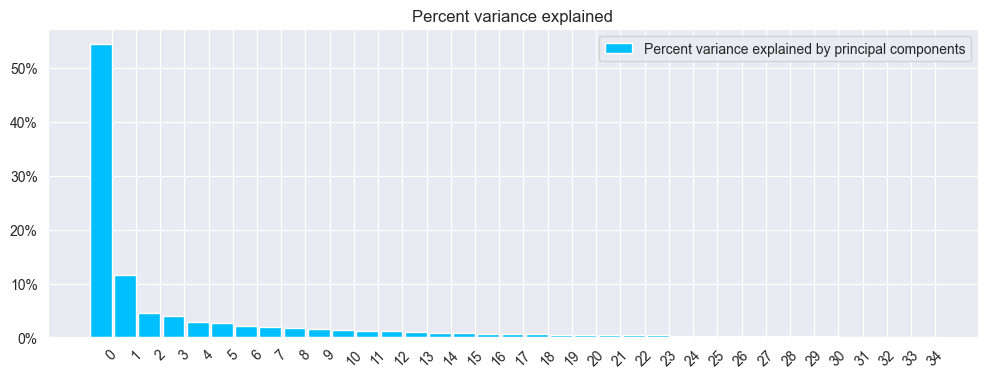

In [8]:
if pca is not None:
    bar_width = 0.9
    n_asset = len(stock_tickers)
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(
        x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color="deepskyblue"
    )

    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax.set_title("Percent variance explained")
    ax.legend((rects[0],), ("Percent variance explained by principal components",))

In [9]:
if pca is not None:
    projected = pca.fit_transform(cov_matrix)

#### Part 3 (Eigen-portfolios construction)

*__Instructions__*:

We now look a the first two eigen portfolios. We use definition of eigen portfolios as provided by Avellaneda ([link](http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf)).  

Following Avellaneda we define eigen portfolio weights as:


<div style="text-align:center">

$\mathcal{Q}^{(j)}_{i} = \frac{{v}^{(j)}_{i}}{{\sigma}^{(j)}_{i}}$

</div>


Where $j$ is the index of eigen portfolio and $v_{i}$ is the $i$-th element of $j$-th eigen vector.
In the code the pca.components_ are the Principal axes in feature space, representing the directions of maximum variance in the data. 
The components are sorted by explained_variance_.

__Hint__: do not forget to normalize portfolio wieghts such they sum up to $1$.

Assign __pc_w__ to be weights of the first eigen portfolio.

Sum of weights of first eigen-portfolio: 100.00


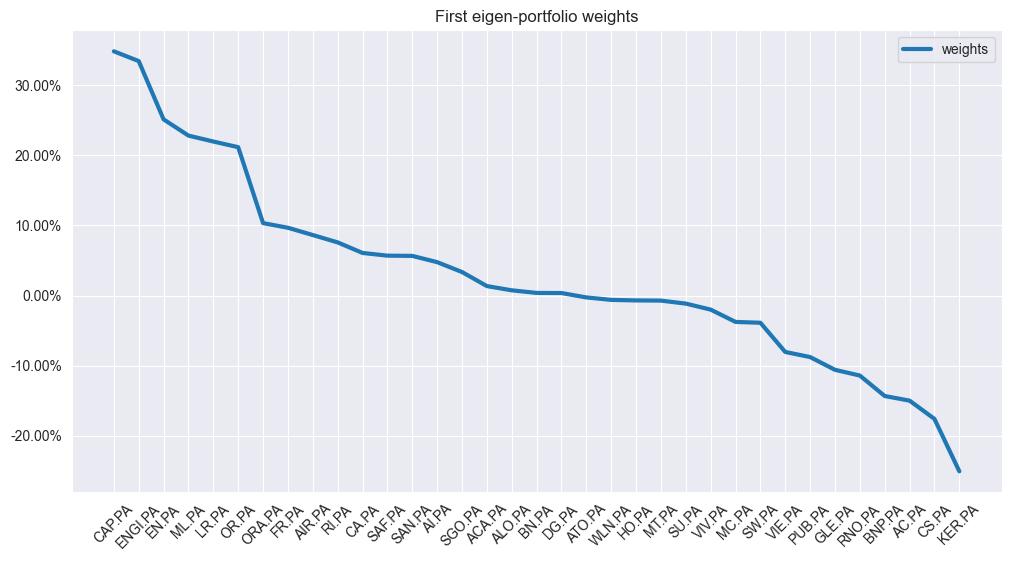

In [10]:
import warnings

warnings.filterwarnings("ignore")

pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data={"weights": pc_w.squeeze() * 100}, index=stock_tickers)
if pca is not None:
    pcs = pca.components_

    # normalized to 1
    pc_w = pcs[:, 0] / sum(pcs[:, 0])
    eigen_prtf1 = pd.DataFrame(
        data={"weights": pc_w.squeeze() * 100}, index=stock_tickers
    )
    eigen_prtf1.sort_values(by=["weights"], ascending=False, inplace=True)
    print("Sum of weights of first eigen-portfolio: %.2f" % np.sum(eigen_prtf1))

    ax = eigen_prtf1.plot(
        title="First eigen-portfolio weights",
        figsize=(12, 6),
        xticks=range(0, len(stock_tickers)),
        rot=45,
        linewidth=3,
    )
    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter_2))
    plt.show()

Sum of weights of second eigen-portfolio: 100.00


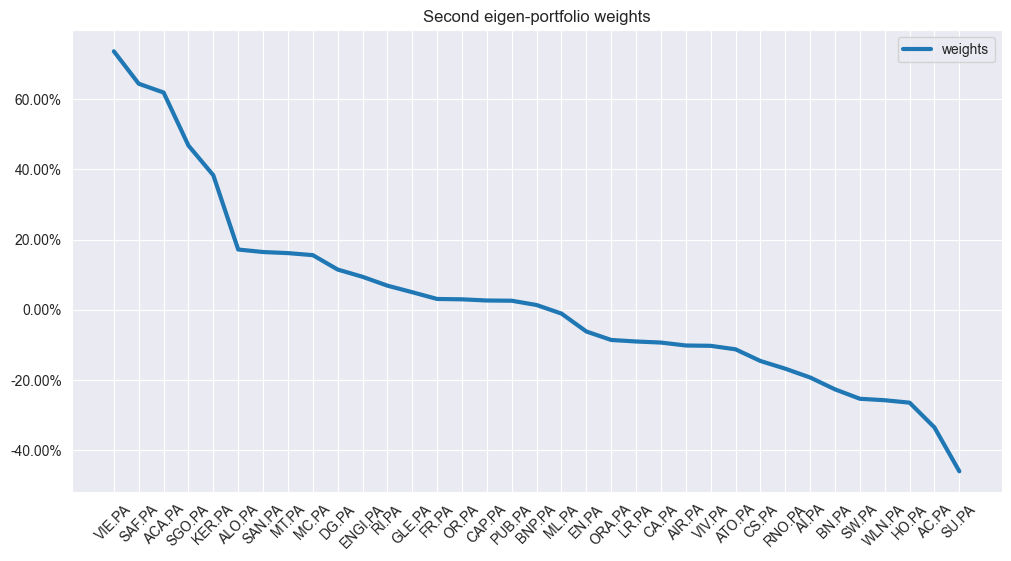

In [11]:
pc_w = np.zeros(len(stock_tickers))
eigen_prtf2 = pd.DataFrame(data={"weights": pc_w.squeeze() * 100}, index=stock_tickers)

if pca is not None:
    pcs = pca.components_

    # normalized to 1
    pc_w = pcs[:, 1] / sum(pcs[:, 1])

    eigen_prtf2 = pd.DataFrame(
        data={"weights": pc_w.squeeze() * 100}, index=stock_tickers
    )
    eigen_prtf2.sort_values(by=["weights"], ascending=False, inplace=True)
    print("Sum of weights of second eigen-portfolio: %.2f" % np.sum(eigen_prtf2))
    ax = eigen_prtf2.plot(
        title="Second eigen-portfolio weights",
        figsize=(12, 6),
        xticks=range(0, len(stock_tickers)),
        rot=45,
        linewidth=3,
    )
    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter_2))
    plt.show()

warnings.filterwarnings("default")

#### Part 4 (Compute performance of several eigen portfolios)

*__Instructions__*:

1. Implement __sharpe_ratio()__ function. The function takes ts_returns argument of type *pd.Series* and returns a tuple of annualized return, annualized vol, and annualized sharpe ratio, where sharpe ratio is defined as annualized return divided by annualized volatility. 

2. Find portfolio (an index into sharpe_metric) that has the highest sharpe ratio. 

In [12]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio,
                    where sharpe ratio is defined as annualized return divided by annualized volatility

    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio

    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """

    annualized_return = 0.0
    annualized_vol = 0.0
    annualized_sharpe = 0.0

    n_years = ts_returns.shape[0] / periods_per_year

    try:
        # If computing error on the annualized return, set return and sharpe to 0
        product = np.prod(1 + ts_returns)
        if np.any(product <= 0):
            raise ValueError("Invalid value encountered in power")

        annualized_return = np.power(product, (1 / n_years)) - 1
        annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
        annualized_sharpe = annualized_return / annualized_vol
    except Exception as e:
        annualized_return = 0.0
        annualized_sharpe = 0.0

    return annualized_return, annualized_vol, annualized_sharpe

We compute the annualized return, volatility, and Sharpe ratio of the first two eigen portfolios.

First eigen-portfolio:
Return = 4.77%
Volatility = 19.61%
Sharpe = 0.24


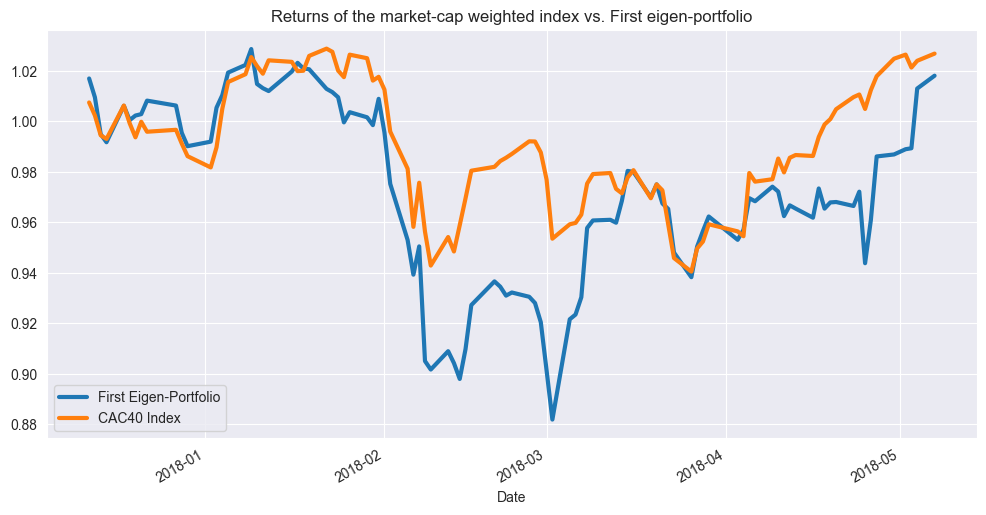

In [13]:
if raw_test_set is not None:
    eigen_prtf1_returns = np.dot(
        raw_test_set.loc[:, eigen_prtf1.index], eigen_prtf1.values / 100
    )

    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=test_set.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print(
        "First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f"
        % (er * 100, vol * 100, sharpe)
    )

    year_frac = (
        eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]
    ).days / 252

    df_plot = pd.DataFrame(
        {
            "First Eigen-Portfolio": eigen_prtf1_returns,
            "CAC40 Index": index_test_set_raw,
        },
        index=test_set.index,
    )

    ax = np.cumprod(df_plot + 1).plot(
        title="Returns of the market-cap weighted index vs. First eigen-portfolio",
        figsize=(12, 6),
        linewidth=3,
    )
    plt.show()

In [14]:
if raw_test_set is not None:
    eigen_prtf2_returns = np.dot(
        raw_test_set.loc[:, eigen_prtf2.index], eigen_prtf2 / 100
    )
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=test_set.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print(
        "Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f"
        % (er * 100, vol * 100, sharpe)
    )

Second eigen-portfolio:
Return = -0.85%
Volatility = 27.85%
Sharpe = -0.03


We repeat the exercise of computing Sharpe ratio for the first N portfolios and select portfolio with the highest postive Sharpe ratio.

Eigen portfolio #23 with the highest Sharpe. Return 186.25%, vol = 33.14%, Sharpe = 5.62


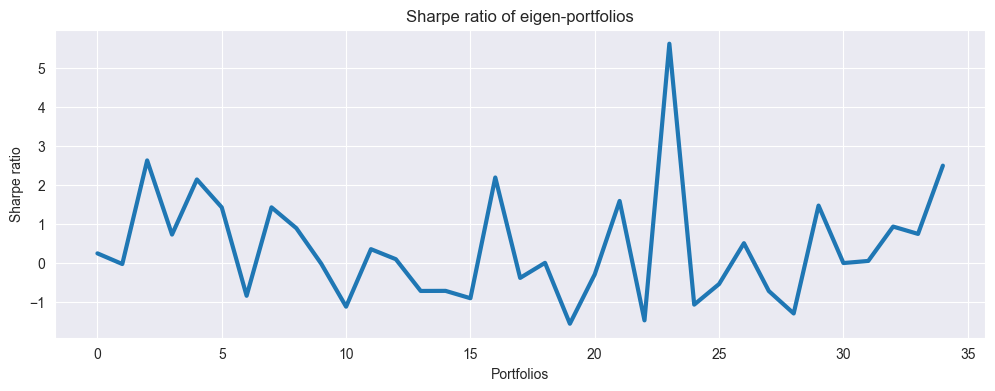

In [15]:
n_portfolios = 35  # Number of stocks available

annualized_ret = np.array(
    [0.0] * n_portfolios
)  # Will contain annualized returns of each portfolio
sharpe_metric = np.array(
    [0.0] * n_portfolios
)  # Will contain annualized sharpe ratio of each portfolio
annualized_vol = np.array(
    [0.0] * n_portfolios
)  # Will contain annualized volatility of each portfolio
idx_highest_sharpe = 0  # index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio

if pca is not None:
    for ix in range(n_portfolios):
        pc_w = pcs[:, ix] / sum(
            pcs[:, ix]
        )  # Compute weights of the ix-th eigen-portfolio and normalize to 1
        eigen_prtfix = pd.DataFrame(
            data={"weights": pc_w.squeeze() * 100}, index=stock_tickers
        )  # Convert array to DataFrame, using stock tickers as index
        eigen_prtfix.sort_values(
            by=["weights"], ascending=False, inplace=True
        )  # Sort the eigen-portfolio by weights

        eigen_prtix_returns = np.dot(
            raw_test_set.loc[:, eigen_prtfix.index], eigen_prtfix / 100
        )  # Compute returns of the ix-th eigen-portfolio
        eigen_prtix_returns = pd.Series(
            eigen_prtix_returns.squeeze(), index=test_set.index
        )  # Convert array to Series, using test_set index

        er, vol, sharpe = sharpe_ratio(
            eigen_prtix_returns
        )  # Compute annualized return, volatility and Sharpe ratio

        annualized_ret[ix] = er  # Store annualized return of the ix-th eigen-portfolio
        annualized_vol[
            ix
        ] = vol  # Store annualized volatility of the ix-th eigen-portfolio
        sharpe_metric[
            ix
        ] = sharpe  # Store annualized Sharpe ratio of the ix-th eigen-portfolio

    idx_highest_sharpe = np.nanargmax(
        sharpe_metric
    )  # Get the index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio

    print(
        "Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f"
        % (
            idx_highest_sharpe,
            annualized_ret[idx_highest_sharpe] * 100,
            annualized_vol[idx_highest_sharpe] * 100,
            sharpe_metric[idx_highest_sharpe],
        )
    )  # Print the eigen-portfolio with the highest Sharpe ratio

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title("Sharpe ratio of eigen-portfolios")
    ax.set_ylabel("Sharpe ratio")
    ax.set_xlabel("Portfolios")

We then print the top 10 eigen-portfolios as identified by the Sharpe ratio constructed. 

In [16]:
results = pd.DataFrame(
    data={"Return": annualized_ret, "Vol": annualized_vol, "Sharpe": sharpe_metric}
)
results.sort_values(by=["Sharpe"], ascending=False, inplace=True)
results.head(10)  #

,Return,Vol,Sharpe
23,1.862490,0.331356,5.620821
2,0.764589,0.290998,2.627470
34,1.617746,0.648886,2.493113
16,0.340172,0.155358,2.189596
4,0.441412,0.206362,2.139015
21,0.497140,0.313104,1.587781
29,0.384205,0.261562,1.468888
7,0.255364,0.179366,1.423701
5,0.183486,0.129023,1.422117
32,0.256729,0.276030,0.930076
